# Step 1: Setting the environment

In [1]:
# Import required packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, decomposition
from scipy import stats
import statsmodels.api as sm

In [2]:
# Clean VCF

vcf_path = f"data/genotypes.vcf"
ann_path = f"data/annotations.txt"

# Get headers
with open(vcf_path, "r") as f:
    for line in f:
        if line.startswith("#CHROM"):
            header = line.strip().lstrip("#").split("\t")
            break

# Load VCF
vcf_df = pd.read_csv(
    vcf_path,
    sep="\t",
    comment="#",
    header=None,
    names=header,
    low_memory=False
)

# Non-sample columns
fixed_cols = ["CHROM", "POS", "ID", "REF", "ALT", "QUAL", "FILTER", "INFO", "FORMAT"]

# Sample columns (all individuals)
sample_cols = [col for col in vcf_df.columns if col not in fixed_cols]

# Remove everything except the first item before ':'
for col in sample_cols:
    vcf_df[col] = vcf_df[col].astype(str).str.split(":").str[0]

## 1a. Exploratory data analysis

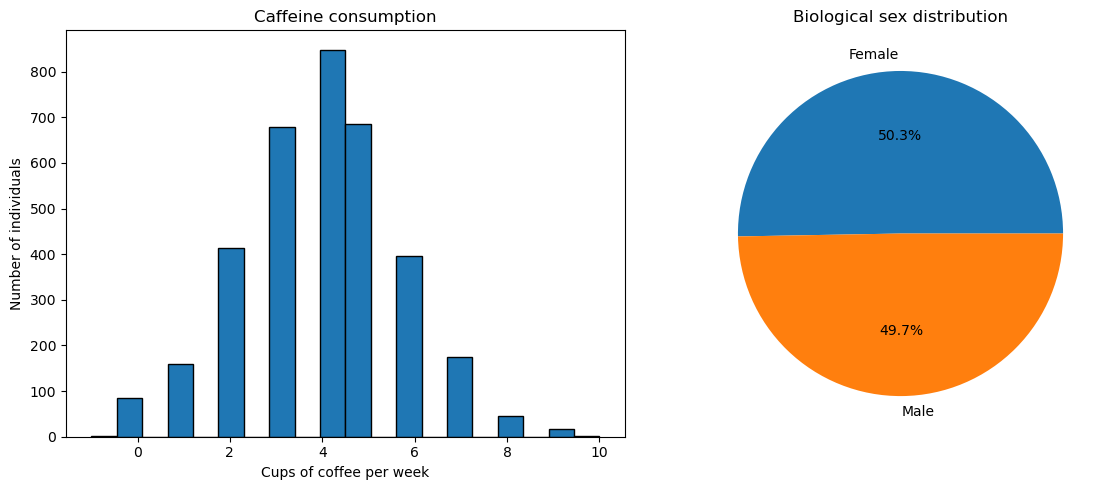

In [3]:
# Plot histogram of caffeine consumption and pie chart for distribution of biological sex

annotations = pd.read_csv(ann_path, sep="\t")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: Histogram of caffeine consumption
axes[0].hist(annotations["CaffeineConsumption"], bins=20, edgecolor="black")
axes[0].set_xlabel("Cups of coffee per week")
axes[0].set_ylabel("Number of individuals")
axes[0].set_title("Caffeine consumption")

# Right: pie chart with Male/Female labels
sex_counts = annotations["isFemale"].value_counts()

axes[1].pie(
    sex_counts,
    labels=[("Female" if str(x).lower() == "true" else "Male") for x in sex_counts.index],
    autopct="%1.1f%%"
)
axes[1].set_title("Biological sex distribution")

plt.tight_layout()
plt.show()

# Step 2: SNP-level filtering - call rate

## 2a. Calculate call rate for each SNP and plot histogram of call rates

In [4]:
# Calculate call rate for each SNP

#Identify sample genotype columns
fixed_cols = ["CHROM", "POS", "ID", "REF", "ALT", "QUAL", "FILTER", "INFO", "FORMAT"]
sample_cols = [col for col in vcf_df.columns if col not in fixed_cols]

# Compute call rate
is_called = (vcf_df[sample_cols] != "./.")
call_rate = is_called.sum(axis=1) / len(sample_cols)
vcf_df = vcf_df.copy()
vcf_df["call_rate"] = call_rate

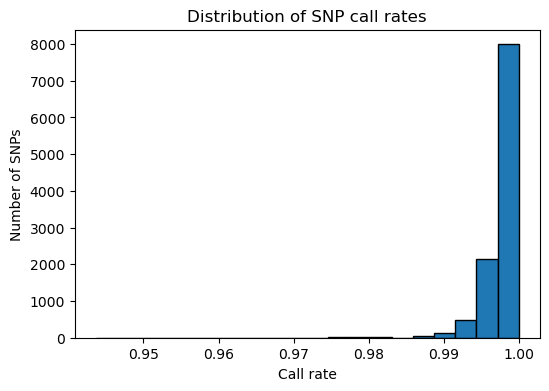

In [5]:
# Plot histogram of call rates

plt.figure(figsize=(6,4))
plt.hist(call_rate, bins=20, edgecolor="black")
plt.xlabel("Call rate")
plt.ylabel("Number of SNPs")
plt.title("Distribution of SNP call rates")
plt.show()

In [6]:
# Keep variants with call rate = 1.0

vcf_filtered = vcf_df[vcf_df["call_rate"] == 1.0]
num_removed = len(vcf_df) - len(vcf_filtered)
print("Number of removed variants due to incomplete data: " + str(num_removed))

Number of removed variants due to incomplete data: 2888


# Step 3: SNP-level filtering - minor allele frequency (MAF)

## 3a. Calculate MAF for each SNP and plot histogram of MAFs for all SNPs

In [7]:
def gt_to_num(gt):
    if gt == "0/0":
        return 0
    elif gt in ["0/1", "1/0"]:
        return 1
    elif gt == "1/1":
        return 2
    else:
        return np.nan

In [8]:
# Calculate MAF for each SNP

# Convert GT to numeric
geno_numeric = vcf_filtered[sample_cols].map(gt_to_num)

# Allele frequency
allele_count = geno_numeric.sum(axis=1)
called = geno_numeric.notna().sum(axis=1)
allele_total = 2 * called
freq = allele_count / allele_total

# Minor allele frequency
maf = np.where(freq <= 0.5, freq, 1 - freq)
vcf_filtered = vcf_filtered.copy()
vcf_filtered["MAF"] = maf

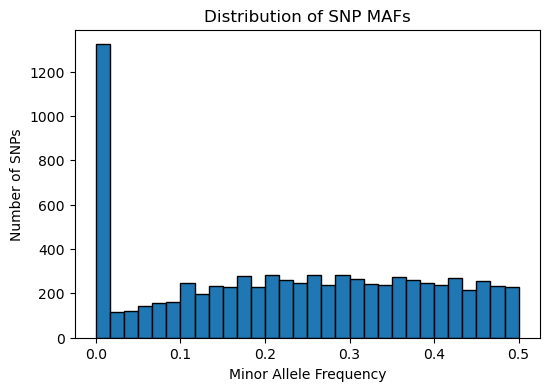

In [9]:
# Plot histogram of all MAFs for all SNPs

plt.figure(figsize=(6,4))
plt.hist(maf, bins=30, edgecolor="black")
plt.xlabel("Minor Allele Frequency")
plt.ylabel("Number of SNPs")
plt.title("Distribution of SNP MAFs")
plt.show()

In [10]:
# Remove variants whose MAF <= 5%

vcf_maf_filtered = vcf_filtered[maf > 0.05]
geno_numeric_filtered = vcf_maf_filtered[sample_cols].map(gt_to_num)
num_removed_maf = len(vcf_filtered) - len(vcf_maf_filtered)
print("Number of removed variants due to low MAF: " + str(num_removed_maf))


Number of removed variants due to low MAF: 1559


The histogram shows a very large spike of SNPs at a very low MAF, followed by a fairly uniform distribution of MAFs between 0.05 and 0.5.

The large spike means that many SNPs are very rare variants that are only present in a few individuals. This is expected because most new mutations came about recently and exist at low frequency.

Common SNPs in the population are spread fairly evenly across different allele frequencies, so once you move past the rare variants, the MAF distribution becomes roughly uniform.

# Step 4: GWAS on the full study cohort

## 4a: Explore potential effect of biological sex on caffeine consumption


### i. Plot boxplot and density plot showing distribution of caffeine consumption by biological sex

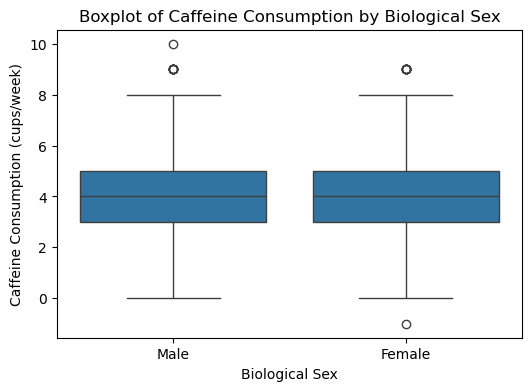

In [11]:
# Plot boxplot

plt.figure(figsize=(6,4))
sns.boxplot(
    data=annotations,
    x="isFemale",
    y="CaffeineConsumption"
)
plt.xticks([0,1], ["Male", "Female"])
plt.xlabel("Biological Sex")
plt.ylabel("Caffeine Consumption (cups/week)")
plt.title("Boxplot of Caffeine Consumption by Biological Sex")
plt.show()

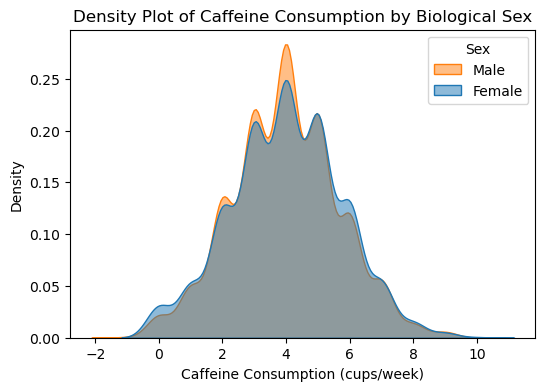

In [12]:
# Plot density plot

plt.figure(figsize=(6,4))
sns.kdeplot(
    data=annotations,
    x="CaffeineConsumption",
    hue="isFemale",
    common_norm=False,
    fill=True,
    alpha=0.5
)
plt.legend(title="Sex", labels=["Male", "Female"])
plt.xlabel("Caffeine Consumption (cups/week)")
plt.title("Density Plot of Caffeine Consumption by Biological Sex")
plt.show()

### ii. Use linear regression to test relationship between caffeine consumption and biological sex

In [13]:
# Linear regression

ann_df = annotations[["CaffeineConsumption", "isFemale"]].dropna()
caffeine_sex_X = ann_df["isFemale"].map({True: 1, False: 0})
caffeine_sex_y = ann_df["CaffeineConsumption"]

# Add constant for intercept
caffeine_sex_X = sm.add_constant(caffeine_sex_X)

# Fit OLS regression
caffeine_sex_model = sm.OLS(caffeine_sex_y, caffeine_sex_X).fit()

# Show regression summary
# print(lr_model.summary())
print("Intercept coefficient: " + str(round(caffeine_sex_model.params.const, 3)))
print("Slope coefficient: " + str(round(caffeine_sex_model.params.isFemale, 3)))
print("R^2: " + str(caffeine_sex_model.rsquared))
print("p-value: " + str(round(caffeine_sex_model.pvalues.isFemale, 3)))

Intercept coefficient: 3.992
Slope coefficient: -0.015
R^2: 1.8596649948632304e-05
p-value: 0.799


We should not include biological sex as a covariate in our analysis because it has virtually no effect on caffeine consumption, given the very low R^2 value and high p-value.

## 4b. Population structure

### i. Calculate principal components of genotype matrix and plot 1st and 2nd PCs

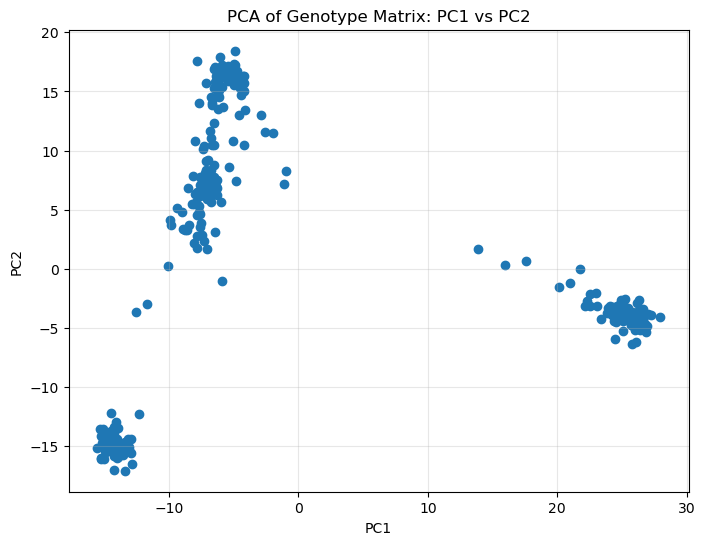

In [14]:
pca = decomposition.PCA(n_components=2)
pcs = pca.fit_transform(geno_numeric_filtered.transpose())
pc_df = pd.DataFrame({
    'PC1': pcs[:, 0],
    'PC2': pcs[:,1]
})

plt.figure(figsize=(8,6))
plt.scatter(pc_df['PC1'], pc_df['PC2'])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Genotype Matrix: PC1 vs PC2")
plt.grid(alpha=0.3)
plt.show()

### ii. Number of data clusters

We can observe 3 data clusters with PC1 and PC2. They represent groups of individuals from different superpopulations, due to differences in allele frequencies across ancestries. We should correct for population structure because ancestry could be a confounding factor in further GWAS.

## 4c. Run GWAS without covariate correction

### i. Use linear regression to test association between SNPs and caffeine consumption

### ii. Extract coefficient of association and p-value for each SNP

In [15]:
ann_df = annotations[["Sample", "CaffeineConsumption"]].dropna()
ann_df = ann_df.set_index("Sample")
no_correction_y = ann_df["CaffeineConsumption"]

no_correction_betas = []
no_correction_pvals = []

snps = geno_numeric_filtered.transpose().columns.tolist()
for snp in snps:
    no_correction_x = geno_numeric_filtered.transpose()[snp]
    tmp_df = pd.DataFrame({'y': no_correction_y, 'x': no_correction_x}).dropna()
    
    if tmp_df['x'].nunique() < 2:
        no_correction_betas.append(np.nan)
        no_correction_pvals.append(np.nan)
        continue
    
    no_correction_X = sm.add_constant(tmp_df['x'])
    no_correction_model = sm.OLS(tmp_df['y'], no_correction_X).fit()

    no_correction_betas.append(no_correction_model.params['x'])
    no_correction_pvals.append(no_correction_model.pvalues['x'])

no_correction_results = pd.DataFrame({
    'SNP': snps,
    'beta': no_correction_betas,
    'pval': no_correction_pvals
}).set_index("SNP")

## 4d. Produce a Manhattan plot

### i. Produce scatterplot with variant's linear position on x-axis and significance of association on y-axis

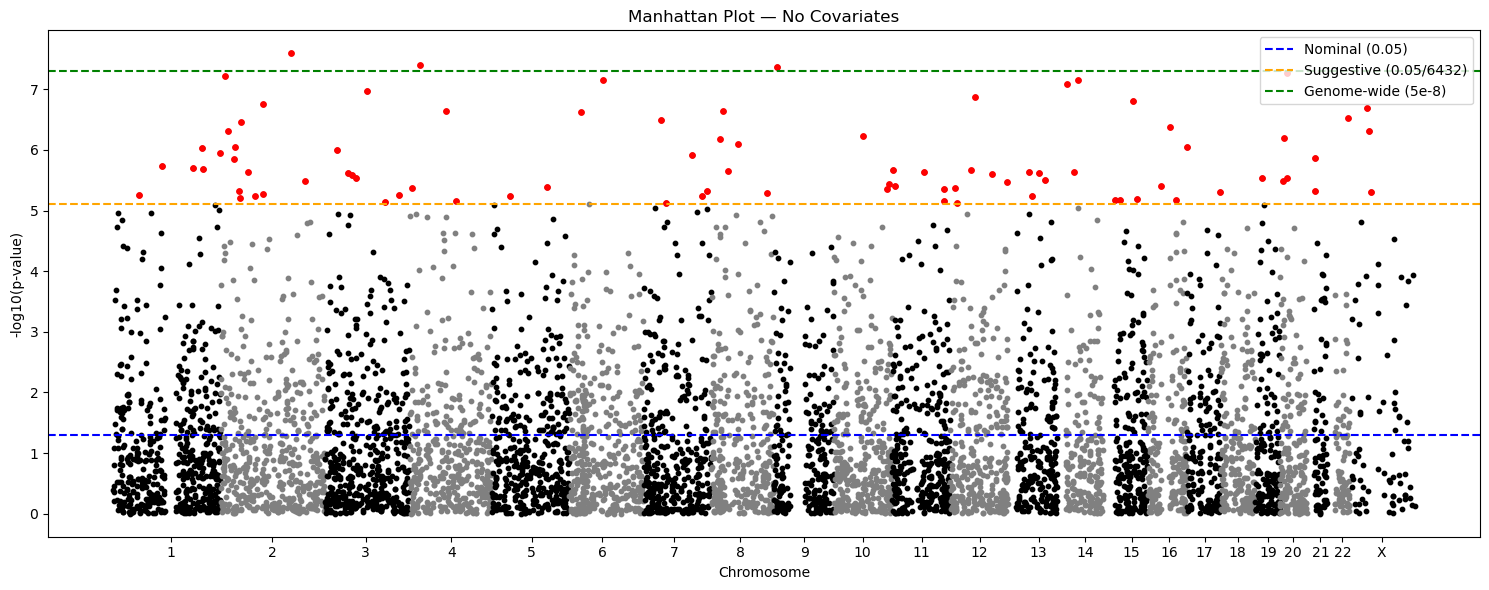

In [16]:
pos = vcf_maf_filtered[['CHROM', 'POS']]
pval = no_correction_results['pval']
df = pd.merge(pos, pval, left_index=True, right_index=True)

# Convert chromosome labels to numeric ordering
chrom_order = [str(i) for i in range(1, 23)] + ["X"]
df["CHROM"] = pd.Categorical(df["CHROM"], categories=chrom_order, ordered=True)
df = df.sort_values(["CHROM", "POS"])

# Add -log10(p) and cumulative positions
df['neglog10p'] = -np.log10(df['pval'])
chrom_sizes = df.groupby('CHROM', observed=True)['POS'].max()
chrom_start = chrom_sizes.cumsum() - chrom_sizes
chrom_start = chrom_start.to_dict()
df["pos_cum"] = df.apply(lambda row: row["POS"] + chrom_start[row["CHROM"]], axis=1)

# Significance thresholds
N = df.shape[0]
p_nominal = 0.05
p_suggestive = 0.05 / N
p_genomewide = 5e-8
thr_nominal = -np.log10(p_nominal)
thr_suggestive = -np.log10(p_suggestive)
thr_genomewide = -np.log10(p_genomewide)

# Manhattan plot
plt.figure(figsize=(15,6))

# Alternating colors by chromosome
colors = ["black", "gray"]
chroms = [c for c in chrom_order if c in df["CHROM"].unique()]

for i, chrom in enumerate(chroms):
    subset = df[df["CHROM"] == chrom]
    plt.scatter(
        subset["pos_cum"],
        subset["neglog10p"],
        s=10,
        color=colors[i % 2]
    )

# Highlight suggestive SNPs
sig_mask = df["pval"] < p_suggestive
plt.scatter(
    df[sig_mask]["pos_cum"],
    df[sig_mask]["neglog10p"],
    s=15,
    color="red"
)

# Threshold lines
plt.axhline(thr_nominal, color="blue", linestyle="--", label="Nominal (0.05)")
plt.axhline(thr_suggestive, color="orange", linestyle="--", label=f"Suggestive (0.05/{N})")
plt.axhline(thr_genomewide, color="green", linestyle="--", label="Genome-wide (5e-8)")

# X-axis ticks at chromosome midpoints
chrom_mid = df.groupby("CHROM", observed=True)["pos_cum"].mean()
plt.xticks(chrom_mid.values, chrom_mid.index)

plt.xlabel("Chromosome")
plt.ylabel("-log10(p-value)")
plt.title("Manhattan Plot — No Covariates")
plt.legend()
plt.tight_layout()
plt.show()

### ii. How many SNPs pass each threshold? Explain the results

In [17]:
n_nominal = (df["pval"] < p_nominal).sum()
n_suggestive = (df["pval"] < p_suggestive).sum()
n_genomewide = (df["pval"] < p_genomewide).sum()

print("SNPs passing nominal (p < 0.05):", n_nominal)
print("SNPs passing suggestive (p < 0.05/N):", n_suggestive)
print("SNPs passing genome-wide (p < 5e-8):", n_genomewide)

SNPs passing nominal (p < 0.05): 2109
SNPs passing suggestive (p < 0.05/N): 86
SNPs passing genome-wide (p < 5e-8): 3


**Nominal significance:**
    Under the null hypothesis, we expect around 5% of SNPS (around 320) to be nominally significant by chance alone. But we observed 2109, which is over 6 times more than expected. The fact that many more SNPs than expected pass the nominal threshold suggests that the phenotype may be influenced by many genetic variants, or that random variation is producing more significant results than expected. It indicates that nominal significance alone is not reliable when testing thousands of SNPs.

**Suggestive threshold:**
    SNPs that pass the suggestive threshold show stronger evidence of association than expected by chance alone. These signals are still not definitive, but they represent the most promising loci that might be worth investigating further.

**Genome-wide significance:**
    Three SNPs meet the conventional genome-wide significance threshold. These variants show very strong statistical evidence of association with caffeine consumption, strong enough that they would be considered credible candidate SNPs in a typical GWAS.

## 4e. Repeat GWAS and Manhattan plot, correcting for covariates based on top 10 PCs

In [18]:
# PCA with 10 components
geno_df_for_pca = geno_numeric_filtered.transpose()
ann_df_for_pca = annotations.set_index("Sample")
ann_sub = ann_df_for_pca.loc[geno_df_for_pca.index]

pca10 = decomposition.PCA(n_components=10, svd_solver="full", random_state=0)
pcs10 = pca10.fit_transform(geno_df_for_pca)
pc_10df = pd.DataFrame(
    pcs10,
    columns=[f"PC{i}" for i in range(1, 11)]
)
pc_10df.insert(0, "Sample", ann_sub.index.values)
pc_10df = pc_10df.set_index("Sample")

In [19]:
# Perform GWAS

df = ann_sub.join(pc_10df).join(geno_df_for_pca)

snp_cols = geno_df_for_pca.columns  # all SNP names
betas = []
pvals = []
snps = []

for snp in snp_cols:

    temp = df[[snp, "CaffeineConsumption"] + [f"PC{i}" for i in range(1,11)]].dropna()

    # Skip monomorphic SNPs
    if temp[snp].nunique() < 2:
        betas.append(np.nan)
        pvals.append(np.nan)
        snps.append(snp)
        continue

    y = temp["CaffeineConsumption"]
    X = temp[[snp] + [f"PC{i}" for i in range(1,11)]]
    X = sm.add_constant(X)

    model = sm.OLS(y, X).fit()

    betas.append(model.params[snp])
    pvals.append(model.pvalues[snp])
    snps.append(snp)

gwas_pc = pd.DataFrame({
    "SNP": snps,
    "beta": betas,
    "pval": pvals
}).set_index("SNP")

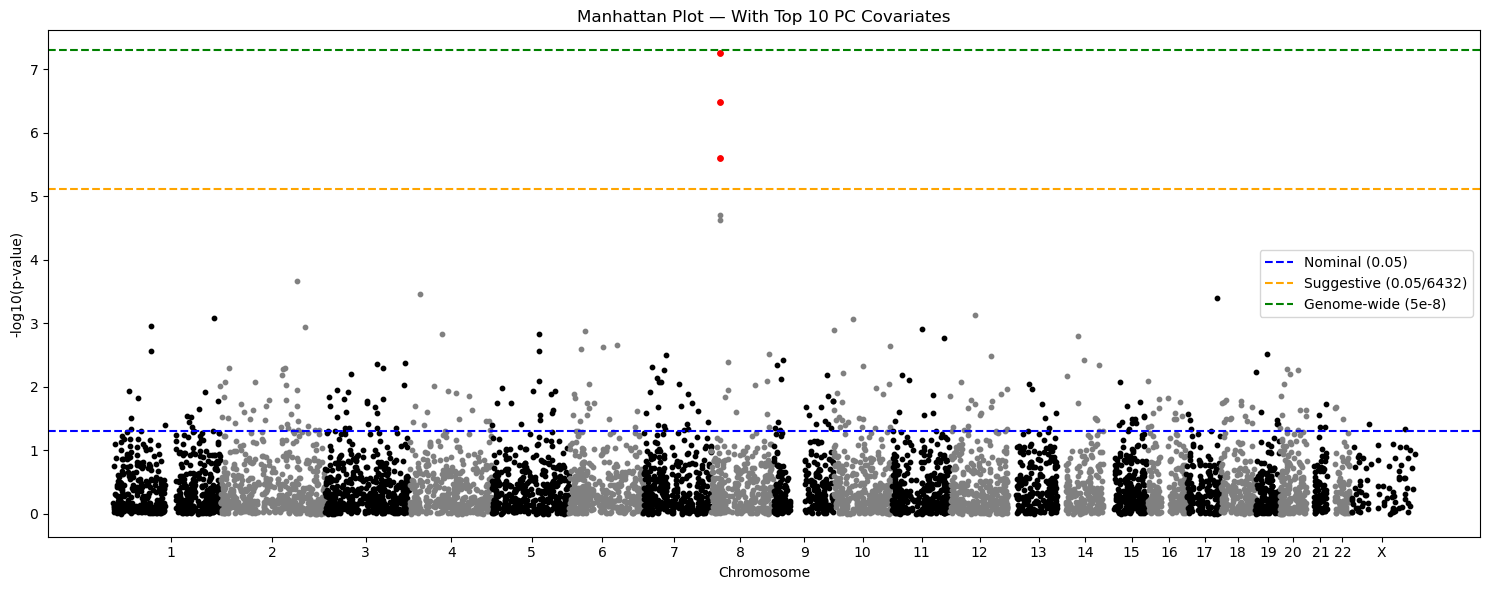

In [20]:
pos = vcf_maf_filtered[['CHROM', 'POS']]
pval = gwas_pc['pval']
df = pd.merge(pos, pval, left_index=True, right_index=True)

# Convert chromosome labels to numeric ordering
chrom_order = [str(i) for i in range(1, 23)] + ["X"]
df["CHROM"] = pd.Categorical(df["CHROM"], categories=chrom_order, ordered=True)
df = df.sort_values(["CHROM", "POS"])

# Add -log10(p) and cumulative positions
df['neglog10p'] = -np.log10(df['pval'])
chrom_sizes = df.groupby('CHROM', observed=True)['POS'].max()
chrom_start = chrom_sizes.cumsum() - chrom_sizes
chrom_start = chrom_start.to_dict()
df["pos_cum"] = df.apply(lambda row: row["POS"] + chrom_start[row["CHROM"]], axis=1)

# Significance thresholds
N = df.shape[0]
p_nominal = 0.05
p_suggestive = 0.05 / N
p_genomewide = 5e-8
thr_nominal = -np.log10(p_nominal)
thr_suggestive = -np.log10(p_suggestive)
thr_genomewide = -np.log10(p_genomewide)

# Manhattan plot
plt.figure(figsize=(15,6))

# Alternating colors by chromosome
colors = ["black", "gray"]
chroms = [c for c in chrom_order if c in df["CHROM"].unique()]

for i, chrom in enumerate(chroms):
    subset = df[df["CHROM"] == chrom]
    plt.scatter(
        subset["pos_cum"],
        subset["neglog10p"],
        s=10,
        color=colors[i % 2]
    )

# Highlight suggestive SNPs
sig_mask = df["pval"] < p_suggestive
plt.scatter(
    df[sig_mask]["pos_cum"],
    df[sig_mask]["neglog10p"],
    s=15,
    color="red"
)

# Threshold lines
plt.axhline(thr_nominal, color="blue", linestyle="--", label="Nominal (0.05)")
plt.axhline(thr_suggestive, color="orange", linestyle="--", label=f"Suggestive (0.05/{N})")
plt.axhline(thr_genomewide, color="green", linestyle="--", label="Genome-wide (5e-8)")

# X-axis ticks at chromosome midpoints
chrom_mid = df.groupby("CHROM", observed=True)["pos_cum"].mean()
plt.xticks(chrom_mid.values, chrom_mid.index)

plt.xlabel("Chromosome")
plt.ylabel("-log10(p-value)")
plt.title("Manhattan Plot — With Top 10 PC Covariates")
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
N = gwas_pc.shape[0]
n_nominal = (gwas_pc["pval"] < 0.05).sum()
n_suggestive = (gwas_pc["pval"] < 0.05 / N).sum()
n_genomewide = (gwas_pc["pval"] < 5e-8).sum()

print("SNPs passing nominal (p < 0.05):", n_nominal)
print("SNPs passing suggestive (p < 0.05/N):", n_suggestive)
print("SNPs passing genome-wide (p < 5e-8):", n_genomewide)

SNPs passing nominal (p < 0.05): 310
SNPs passing suggestive (p < 0.05/N): 3
SNPs passing genome-wide (p < 5e-8): 0


### i. How does correcting for the top 10 PCs change the results?

After including the top 10 PCs as covariates, the number of significant SNPs decreased by a lot, and all genome-wide significant associations disappeared. This shows that many apparent SNP associations in the uncorrected analysis were driven by population structure rather than true genetic relationships to caffeine consumption.

### ii. Report the p-value and Beta for the most significant SNP

In [22]:
best = gwas_pc.loc[gwas_pc["pval"].idxmin()]
print("Most significant SNP (PC corrected):")
print(best)

Most significant SNP (PC corrected):
beta    8.045174e-01
pval    5.588198e-08
Name: 5112, dtype: float64


## 4f. Repeat GWAS and Manhattan plot, correcting for SuperPopulation

In [23]:
# Perform GWAS

df = ann_sub.join(geno_df_for_pca)

snp_cols = geno_df_for_pca.columns  # all SNP names
betas = []
pvals = []
snps = []

# Convert SuperPopulation into one-hot encoded covariates
supop_dummies = pd.get_dummies(df["SuperPopulation"], drop_first=True)
supop_dummies = supop_dummies.astype(int)

# Add these columns to df
for col in supop_dummies.columns:
    df[col] = supop_dummies[col]

covars = supop_dummies.columns.tolist()

for snp in snp_cols:

    temp = df[[snp, "CaffeineConsumption"] + covars].dropna()

    # Skip monomorphic SNPs
    if temp[snp].nunique() < 2:
        betas.append(np.nan)
        pvals.append(np.nan)
        snps.append(snp)
        continue

    y = temp["CaffeineConsumption"]
    X = temp[[snp] + covars]
    X = sm.add_constant(X)

    model = sm.OLS(y, X).fit()

    betas.append(model.params[snp])
    pvals.append(model.pvalues[snp])
    snps.append(snp)

gwas_supop = pd.DataFrame({
    "SNP": snps,
    "beta": betas,
    "pval": pvals
}).set_index("SNP")

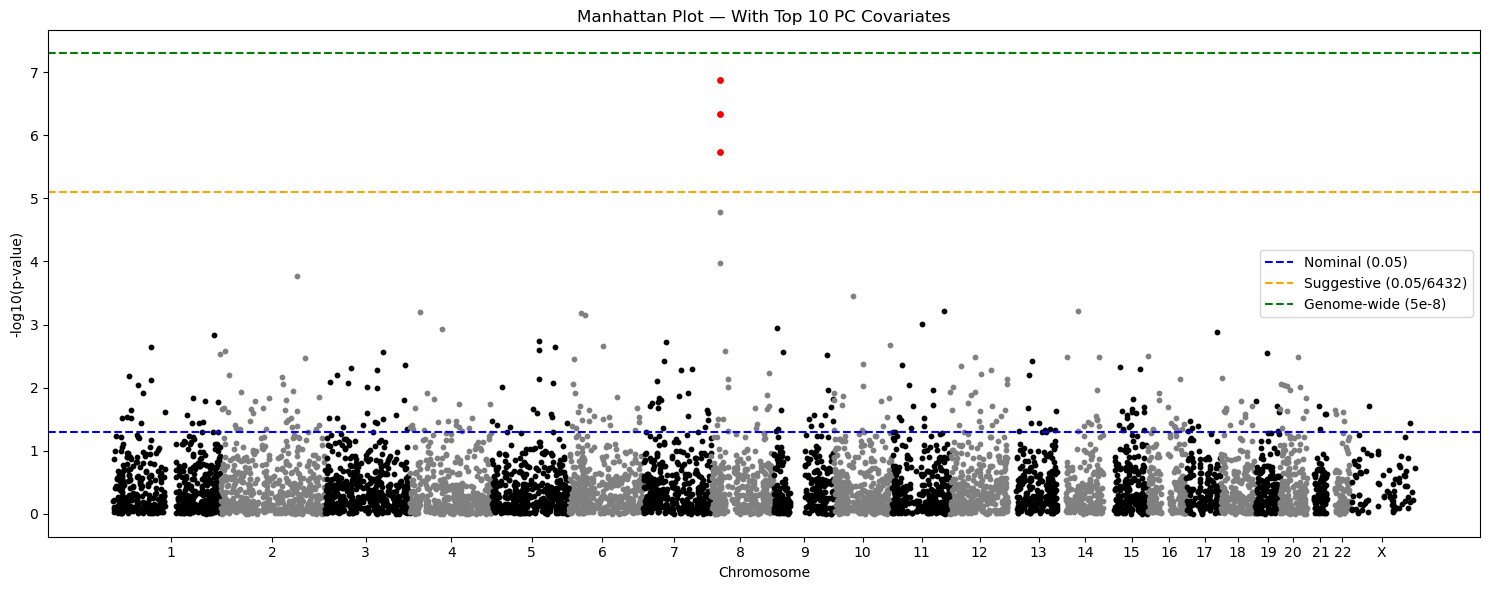

In [24]:
pos = vcf_maf_filtered[['CHROM', 'POS']]
pval = gwas_supop['pval']
df = pd.merge(pos, pval, left_index=True, right_index=True)

# Convert chromosome labels to numeric ordering
chrom_order = [str(i) for i in range(1, 23)] + ["X"]
df["CHROM"] = pd.Categorical(df["CHROM"], categories=chrom_order, ordered=True)
df = df.sort_values(["CHROM", "POS"])

# Add -log10(p) and cumulative positions
df['neglog10p'] = -np.log10(df['pval'])
chrom_sizes = df.groupby('CHROM', observed=True)['POS'].max()
chrom_start = chrom_sizes.cumsum() - chrom_sizes
chrom_start = chrom_start.to_dict()
df["pos_cum"] = df.apply(lambda row: row["POS"] + chrom_start[row["CHROM"]], axis=1)

# Significance thresholds
N = df.shape[0]
p_nominal = 0.05
p_suggestive = 0.05 / N
p_genomewide = 5e-8
thr_nominal = -np.log10(p_nominal)
thr_suggestive = -np.log10(p_suggestive)
thr_genomewide = -np.log10(p_genomewide)

# Manhattan plot
plt.figure(figsize=(15,6))

# Alternating colors by chromosome
colors = ["black", "gray"]
chroms = [c for c in chrom_order if c in df["CHROM"].unique()]

for i, chrom in enumerate(chroms):
    subset = df[df["CHROM"] == chrom]
    plt.scatter(
        subset["pos_cum"],
        subset["neglog10p"],
        s=10,
        color=colors[i % 2]
    )

# Highlight suggestive SNPs
sig_mask = df["pval"] < p_suggestive
plt.scatter(
    df[sig_mask]["pos_cum"],
    df[sig_mask]["neglog10p"],
    s=15,
    color="red"
)

# Threshold lines
plt.axhline(thr_nominal, color="blue", linestyle="--", label="Nominal (0.05)")
plt.axhline(thr_suggestive, color="orange", linestyle="--", label=f"Suggestive (0.05/{N})")
plt.axhline(thr_genomewide, color="green", linestyle="--", label="Genome-wide (5e-8)")

# X-axis ticks at chromosome midpoints
chrom_mid = df.groupby("CHROM", observed=True)["pos_cum"].mean()
plt.xticks(chrom_mid.values, chrom_mid.index)

plt.xlabel("Chromosome")
plt.ylabel("-log10(p-value)")
plt.title("Manhattan Plot — With Top 10 PC Covariates")
plt.legend()
plt.tight_layout()
plt.show()

In [25]:
N = gwas_supop.shape[0]
n_nominal = (gwas_supop["pval"] < 0.05).sum()
n_suggestive = (gwas_supop["pval"] < 0.05 / N).sum()
n_genomewide = (gwas_supop["pval"] < 5e-8).sum()

print("SNPs passing nominal (p < 0.05):", n_nominal)
print("SNPs passing suggestive (p < 0.05/N):", n_suggestive)
print("SNPs passing genome-wide (p < 5e-8):", n_genomewide)

SNPs passing nominal (p < 0.05): 327
SNPs passing suggestive (p < 0.05/N): 3
SNPs passing genome-wide (p < 5e-8): 0


### i. Describe the results

327 nominal SNPs is almost exactly what you would expect by random chance under the p < 0.05 threshold. This means that population structure caused most of the original false positives.

Nearly all suggestive associations disappear once you adjust for population group, showing that most of the signals in the uncorrected GWAS were driven by differences between superpopulations rather than real genotype–phenotype association.

The SNPs that looked genome-wide significant in the uncorrected GWAS were actually false positives driven by population differences. Once you add SuperPopulation as a covariate, these disappear completely.

Using SuperPopulation labels reduces most of the false-positive inflation from population structure, but it does not eliminate all of it. PCA-based correction removes substantially more structure, especially subtle differences within each superpopulation, leading to even fewer significant SNPs. Therefore, the PCA results show a cleaner, more conservative GWAS.

### ii. Which approach would you prefer?

In general, PCA-based correction is preferred because principal components capture both broad and fine-scale genetic structure directly from the genotype data. SuperPopulation labels only adjust for very coarse, discrete groups and cannot account for subtle variation within each group. Therefore, PCA provides a more accurate and reliable correction for population stratification in GWAS.

In [26]:
# === Patched Compatibility Cell for Step 5 ===
# This version automatically searches for VCF + annotations in common folders,
# including ./ , ./data , ./Data , ./resources , /mnt/data

import os
import numpy as np
import pandas as pd

def find_file(filename, extra_terms=None):
    """
    Searches for a file in:
    - current working directory
    - ./data, ./Data, ./dataset, ./resources
    - /mnt/data
    Returns full path if found, else None.
    """
    search_paths = ['.', './data', './Data', './dataset', './resources', '/mnt/data']

    # Add any additional search paths
    if extra_terms:
        for t in extra_terms:
            search_paths.append(t)

    for p in search_paths:
        candidate = os.path.join(p, filename)
        if os.path.exists(candidate):
            return candidate

    return None


# ====================================================
# 1. Load annotations
# ====================================================
if 'annot_df' in globals():
    print("Using existing annot_df from notebook variables.")
    annot_df = globals()['annot_df']

else:
    annot_file = None
    for fname in ["annotations.txt", "annotations.tsv", "annotations.csv"]:
        annot_file = find_file(fname)
        if annot_file:
            break

    if annot_file is None:
        raise FileNotFoundError(
            "Could not find annotations file. Expected one of:\n"
            "- annotations.txt\n- annotations.tsv\n- annotations.csv\n"
            "Search paths tested include: ., ./data, /mnt/data\n"
            "Please check os.listdir() to verify location."
        )

    print(f"Loading annotations from: {annot_file}")
    annot_df = pd.read_csv(annot_file, sep=None, engine='python')
    annot_df.columns = [c.strip() for c in annot_df.columns]

    # Standardize column names if needed
    if "Sample" in annot_df.columns:
        annot_df = annot_df.rename(columns={
            "Sample": "sampleID",
            "CaffeineConsumption": "caffeine",
            "isFemale": "isFemale",
            "SuperPopulation": "SuperPopulation"
        })

    if 'sampleID' not in annot_df.columns:
        annot_df = annot_df.rename(columns={annot_df.columns[0]: 'sampleID'})

    if "caffeine" not in annot_df.columns:
        # attempt auto-detection
        for c in annot_df.columns:
            if "caff" in c.lower() or "coffee" in c.lower():
                annot_df = annot_df.rename(columns={c: "caffeine"})
                break

    if "SuperPopulation" not in annot_df.columns:
        for c in annot_df.columns:
            if "pop" in c.lower():
                annot_df = annot_df.rename(columns={c: "SuperPopulation"})
                break

    annot_df = annot_df.set_index(annot_df['sampleID'].astype(str))
    print("Annotations loaded. Total samples:", len(annot_df))


# ====================================================
# 2. Load genotype matrix (VCF or cleaned VCF)
# ====================================================
if ("G" in globals()) and ("samples" in globals()) and ("variants" in globals()):
    print("Using existing G, samples, and variants in notebook.")
    G = globals()['G']
    samples = globals()['samples']
    variants = globals()['variants']

else:
    # Search for VCF files
    vcf_path = None
    for fname in ["genotypes_cleaned.vcf", "genotypes.vcf", "genotypes_gt.vcf"]:
        vcf_path = find_file(fname)
        if vcf_path:
            break

    if vcf_path is None:
        raise FileNotFoundError(
            "Could not locate any VCF file. Expected one of:\n"
            "- genotypes_cleaned.vcf\n- genotypes.vcf\n- genotypes_gt.vcf\n"
            "Please verify file location using os.listdir()."
        )

    print(f"Loading GT-only VCF from: {vcf_path}")

    variants = []
    samples = []
    G_rows = []

    with open(vcf_path) as fh:
        for ln in fh:
            if ln.startswith("##"):
                continue
            if ln.startswith("#CHROM"):
                header = ln.strip().split("\t")
                samples = header[9:]
                continue

            parts = ln.strip().split("\t")
            chrom, pos, vid = parts[0], int(parts[1]), parts[2]
            sample_fields = parts[9:]

            row = []
            for gtentry in sample_fields:
                gt = gtentry.split(":")[0] if ":" in gtentry else gtentry
                gt = gt.replace("|", "/")
                if gt in ["./.", ".", ""]:
                    row.append(np.nan)
                else:
                    a1, a2 = gt.split("/")
                    try:
                        a1 = int(a1) if a1 != "." else np.nan
                        a2 = int(a2) if a2 != "." else np.nan
                        row.append(a1 + a2 if np.isfinite(a1) and np.isfinite(a2) else np.nan)
                    except:
                        row.append(np.nan)

            variants.append({"chrom": chrom, "pos": pos, "id": vid})
            G_rows.append(row)

    G = np.array(G_rows, dtype=float)
    samples = [str(s) for s in samples]

    print(f"Loaded genotype matrix: {G.shape[0]} variants × {G.shape[1]} samples")


# ====================================================
# 3. Sync annotations to VCF order
# ====================================================
missing = set(samples) - set(annot_df.index)
if missing:
    raise ValueError(f"Some VCF samples missing from annotations: {list(missing)[:10]}")

annot_df = annot_df.loc[samples]  # reorder to VCF sample order

print("\n✓ Compatibility check complete.")
print(f"G matrix shape: {G.shape}")
print(f"Samples: {len(samples)}")
print(f"Annotation columns available: {annot_df.columns.tolist()}")


Loading annotations from: ./data/annotations.txt
Annotations loaded. Total samples: 3500
Loading GT-only VCF from: ./data/genotypes_cleaned.vcf
Loaded genotype matrix: 10879 variants × 284 samples

✓ Compatibility check complete.
G matrix shape: (10879, 284)
Samples: 284
Annotation columns available: ['sampleID', 'SuperPopulation', 'isFemale', 'caffeine']


In [30]:
# 5a: split by superpopulation
import numpy as np
import pandas as pd

def maf_from_vector(g):
    """compute MAF from genotype vector of 0/1/2/nan values"""
    mask = np.isfinite(g)
    if mask.sum() == 0:
        return np.nan
    alt_count = np.nansum(g[mask])
    alt_freq = alt_count / (2 * mask.sum())
    return min(alt_freq, 1 - alt_freq)
pop_labels = annot_df["SuperPopulation"].astype(str).values
unique_pops = np.unique(pop_labels)

pop_keep_indices = {}
pop_summary = []

MAF_THRESHOLD = 0.05

for pop in unique_pops:
    sample_idx = np.where(pop_labels == pop)[0]
    G_sub = G[:, sample_idx]

    mafs = np.apply_along_axis(maf_from_vector, 1, G_sub)
    keep_mask = mafs > MAF_THRESHOLD
    keep_indices = np.where(keep_mask)[0]

    pop_keep_indices[pop] = keep_indices
    pop_summary.append({
        "Population": pop,
        "Samples": len(sample_idx),
        "Variants_after_MAF": len(keep_indices)
    })

    print(f"{pop}: kept {len(keep_indices)} variants")

    pop_summary_df = pd.DataFrame(pop_summary)
    display(pop_summary_df)

    pop_summary_df.to_csv("step5a_population_variant_summary.csv", index=False)
    print("\nSaved -> step5a_population_variant_summary.csv")

AFR: kept 8163 variants


,Population,Samples,Variants_after_MAF
0,AFR,76,8163



Saved -> step5a_population_variant_summary.csv
AMR: kept 8119 variants


,Population,Samples,Variants_after_MAF
0,AFR,76,8163
1,AMR,34,8119



Saved -> step5a_population_variant_summary.csv
EAS: kept 7572 variants


,Population,Samples,Variants_after_MAF
0,AFR,76,8163
1,AMR,34,8119
2,EAS,72,7572



Saved -> step5a_population_variant_summary.csv
EUR: kept 7962 variants


,Population,Samples,Variants_after_MAF
0,AFR,76,8163
1,AMR,34,8119
2,EAS,72,7572
3,EUR,47,7962



Saved -> step5a_population_variant_summary.csv
SAS: kept 8047 variants


,Population,Samples,Variants_after_MAF
0,AFR,76,8163
1,AMR,34,8119
2,EAS,72,7572
3,EUR,47,7962
4,SAS,55,8047



Saved -> step5a_population_variant_summary.csv


In [37]:
# 5b: intersect variants across populations

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import statsmodels.api as sm

os.makedirs("step5_output", exist_ok=True)

NUM_PCS = 10
SUGGESTIVE_P = 1e-5

gwas_results = {}

def run_single_snp(y, snp_vec, covariates):
    """Run linear regression: caffeine ~ SNP + PCs."""
    mask = np.isfinite(y) & np.isfinite(snp_vec)
    if mask.sum() < 10:
        return np.nan, np.nan
    X = np.column_stack([snp_vec[mask], covariates[mask]])
    X = sm.add_constant(X)
    model = sm.OLS(y[mask], X).fit()
    beta = model.params[1]
    pval = model.pvalues[1]
    return beta, pval

for pop in unique_pops:
    print(f"\nRunning GWAS for population: {pop}")

    sample_idx = np.where(pop_labels == pop)[0]
    pheno = annot_df["caffeine"].values[sample_idx].astype(float)

    keep = pop_keep_indices[pop]
    G_sub = G[keep][:, sample_idx]

    G_imp = np.where(np.isnan(G_sub), np.nanmean(G_sub, axis=1, keepdims=True), G_sub)
    PCs = PCA(n_components=min(NUM_PCS, G_imp.shape[1], G_imp.shape[0]), random_state=0).fit_transform(G_imp.T)

    Beta = []
    Pval = []
    Vid = []

    for idx_local, global_idx in enumerate(keep):
        snp_vec = G_sub[idx_local, :]
        beta, p = run_single_snp(pheno, snp_vec, PCs)
        Beta.append(beta)
        Pval.append(p)
        Vid.append(global_idx)

    df = pd.DataFrame({
        "variant_idx": Vid,
        "beta": Beta,
        "pvalue": Pval,
        "chrom": [variants[i]["chrom"] for i in Vid],
        "pos": [variants[i]["pos"] for i in Vid],
        "id": [variants[i]["id"] for i in Vid]
    })

    gwas_results[pop] = df
    df.to_csv(f"step5b_gwas_{pop}.csv", index=False)

    dF_sorted = df.sort_values(["chrom", "pos"]).reset_index(drop=True)
    dF_sorted["x"] = range(len(dF_sorted))
    dF_sorted["-log10p"] = -np.log10(dF_sorted["pvalue"].replace(0, 1e-300))

    plt.figure(figsize=(10, 4))
    plt.scatter(dF_sorted["x"], dF_sorted["-log10p"], s=6)
    plt.axhline(-np.log10(SUGGESTIVE_P), color="red", linestyle="--")
    plt.title(f"Manhattan Plot - {pop}")
    plt.xlabel("Genome Position")
    plt.ylabel("-log10(p)")
    plt.tight_layout()
    plt.savefig(f"step5_output/manhattan_{pop}.png", dpi=150)
    plt.close()

    print(f"Saved GWAS results and Manhattan plot for {pop}.")


Running GWAS for population: AFR
Saved GWAS results and Manhattan plot for AFR.

Running GWAS for population: AMR
Saved GWAS results and Manhattan plot for AFR.

Running GWAS for population: AMR
Saved GWAS results and Manhattan plot for AMR.

Running GWAS for population: EAS
Saved GWAS results and Manhattan plot for AMR.

Running GWAS for population: EAS
Saved GWAS results and Manhattan plot for EAS.

Running GWAS for population: EUR
Saved GWAS results and Manhattan plot for EAS.

Running GWAS for population: EUR
Saved GWAS results and Manhattan plot for EUR.

Running GWAS for population: SAS
Saved GWAS results and Manhattan plot for EUR.

Running GWAS for population: SAS
Saved GWAS results and Manhattan plot for SAS.
Saved GWAS results and Manhattan plot for SAS.


In [ ]:
# 5c: fisher meta-analysis

from scipy.stats import chi2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Find common variants across all populations (intersection)
common_variants = set(pop_keep_indices[unique_pops[0]])
for pop in unique_pops[1:]:
    common_variants &= set(pop_keep_indices[pop])
common_variants = sorted(list(common_variants))

print(f"{len(common_variants)} variants kept in all populations after MAF filtering.")

meta_rows = []

for vi in common_variants:
    pvals = []
    ok = True

    for pop in unique_pops:
        df = gwas_results.get(pop)
        if df is None:
            ok = False
            break
        row = df[df["variant_idx"] == vi]
        if row.empty:
            ok = False
            break
        pv = row["pvalue"].values[0]
        if not np.isfinite(pv):
            ok = False
            break
        # guard against zero p-values when taking logs
        pv = max(pv, 1e-300)
        pvals.append(pv)

    if not ok:
        continue

    stat = -2 * np.sum(np.log(pvals))
    df_chi2 = 2 * len(pvals)
    meta_p = 1 - chi2.cdf(stat, df_chi2)

    meta_rows.append({
        "variant_idx": vi,
        "chrom": variants[vi]["chrom"],
        "pos": variants[vi]["pos"],
        "id": variants[vi]["id"],
        "meta_p": meta_p
    })

meta_df = pd.DataFrame(meta_rows).sort_values(["chrom", "pos"]) 
meta_df.to_csv("step5c_meta_analysis_results.csv", index=False)

meta_df["x"] = range(len(meta_df))
meta_df["-log10p"] = -np.log10(meta_df["meta_p"].replace(0, 1e-300))

plt.figure(figsize=(12, 4))
plt.scatter(meta_df["x"], meta_df["-log10p"], s=6)
plt.axhline(-np.log10(SUGGESTIVE_P), color="red", linestyle="--")
plt.title("Fisher Meta-Analysis Manhattan Plot")
plt.xlabel("Genome Position")
plt.ylabel("-log10(meta p)")
plt.tight_layout()
plt.savefig("step5_output/manhattan_meta_analysis.png", dpi=180)
plt.close()

print("Saved Fisher meta-analysis output and Manhattan plot.")

8047 variants kept in all populations after MAF filtering.


KeyError: 'chrom'